# END TO END ML USING SNOWPARK AND SCIKIT-LEARN

In this notebook we fit/train a Scikit-Learn ML pipeline that includes common feature engineering tasks such as Imputations, Scaling and One-Hot Encoding. The pipeline also includes a `RandomForestRegressor` model that will predict member lifetime value for ecommerce customers. 

We will fit/train the pipeline using a Snowpark Python Stored Procedure (SPROC) and then save the pipeline to a Snowflake stage. This example concludes by showing how a saved model/pipeline can be loaded and run in a scalable fashion on a snowflake warehouse using Snowpark Python User-Defined Functions (UDFs). 

![Snowpark ML](images/snowpark_ml.png)

### Create a session with Snowpark connector

In [1]:
# Snowpark
import snowflake.snowpark
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import sproc, udf, udtf
from snowflake.snowpark.session import Session
from snowflake.snowpark import version as v
from snowflake.snowpark import types as T
from snowflake.snowpark.window import Window
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import preprocessing #https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities

import pandas as pd
import numpy as np
import datetime
import io
import os
import joblib

with open('creds.json') as f:
    connection_parameters = json.load(f)

session = Session.builder.configs(connection_parameters).create()
session.add_packages('snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools')

The version of package cachetools in the local environment is 5.2.0, which does not fit the criteria for the requirement cachetools. Your UDF might not work when the package version is different between the server and your local environment


In [2]:
print(f"""
    ROLE: {session.get_current_role()}
    DATABASE: {session.get_current_database()}
    SCHEMA: {session.get_current_schema()}
    WAREHOUSE: {session.get_current_warehouse()}
""")


    ROLE: "SNOWPARK_DEMO_ROLE"
    DATABASE: "SNOWPARK_DEMO_DB"
    SCHEMA: "MEMBERSHIP_MODELING_DEMO"
    WAREHOUSE: "SNOWPARK_DEMO_WH"



In [3]:
session.sql("alter warehouse snowpark_demo_wh set warehouse_size='SMALL'").collect()

[Row(status='Statement executed successfully.')]

### Create stages to save the ML model/pipeline and permanent UDFs

In [4]:
query = """create or replace stage models
           directory = (enable = true)
           copy_options = (on_error='skip_file')"""

session.sql(query).collect()

[Row(status='Stage area MODELS successfully created.')]

In [5]:
query = "create or replace stage udf" +\
        " copy_options = (on_error='skip_file')"

session.sql(query).collect()
session.file.put("preprocessing.zip", '@udf', auto_compress=False, overwrite=True)     

[PutResult(source='preprocessing.zip', target='preprocessing.zip', source_size=29226, target_size=29232, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

## Explore Snowflake data using Snowpark

In [6]:
snowdf = session.table("ECOMMERCE_CUSTOMERS_100K")

In [7]:
snowdf.describe().to_pandas()

,SUMMARY,EMAIL,GENDER,MEMBERSHIP_STATUS,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT
0,count,100000,100000,100000,97594.000000,98573.000000,100000.000000,100000.000000,100000.000000
1,mean,None,None,None,4.525396,22.619508,180.594324,81.109729,450.750051
2,stddev,None,None,None,2.285851,7.618244,70.971802,32.487229,152.028727
3,min,002vohjzbl@wxftu.com,FEMALE,BASIC,0.000000,3.899405,4.192654,-29.306218,0.000000
4,max,zzzx5pr2mq@mnejx.com,UNKNOWN,SILVER,13.641156,56.309331,371.296055,175.859280,1170.450219


In [8]:
snowdf.limit(10).to_pandas()

,EMAIL,GENDER,MEMBERSHIP_STATUS,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT
0,u2otqqt9zm@mvkfh.com,FEMALE,PLATIN,5.888660,28.158552,267.363315,86.526823,593.047398
1,wb5wjjaqxy@t6rfz.com,FEMALE,GOLD,3.498752,27.481113,235.796911,132.750487,537.462363
2,yxj7x9fv4v@c9xm0.com,MALE,GOLD,6.255048,24.706348,161.974076,68.819486,586.785886
3,vxx9nj4zzl@4qi8i.com,MALE,GOLD,7.100007,19.466667,185.490152,71.741045,541.195579
4,lqfuxk2yye@q6vkm.com,FEMALE,GOLD,4.149268,21.907570,168.915367,49.228441,523.498353
5,zyw592ipl4@jjtts.com,FEMALE,GOLD,2.475507,22.785610,190.663957,90.214381,475.882829
6,zimmyjayvf@cc8zy.com,FEMALE,SILVER,3.750613,9.021774,121.163521,86.011650,276.153585
7,uylwvm0kba@euio4.com,FEMALE,GOLD,3.908891,27.380003,169.418093,80.167749,382.280718
8,zxm5qc6uul@wz5na.com,FEMALE,GOLD,5.540958,24.946123,209.815451,119.976333,535.160665
9,13gnfz2liu@d3zz0.com,FEMALE,SILVER,2.252396,16.554653,107.699240,49.793487,319.050478


In [9]:
cat_attribs = ['GENDER','MEMBERSHIP_STATUS']
num_attribs = ['MEMBERSHIP_LENGTH', 'AVG_SESSION_LENGTH', 'TIME_ON_APP', 'TIME_ON_WEBSITE']

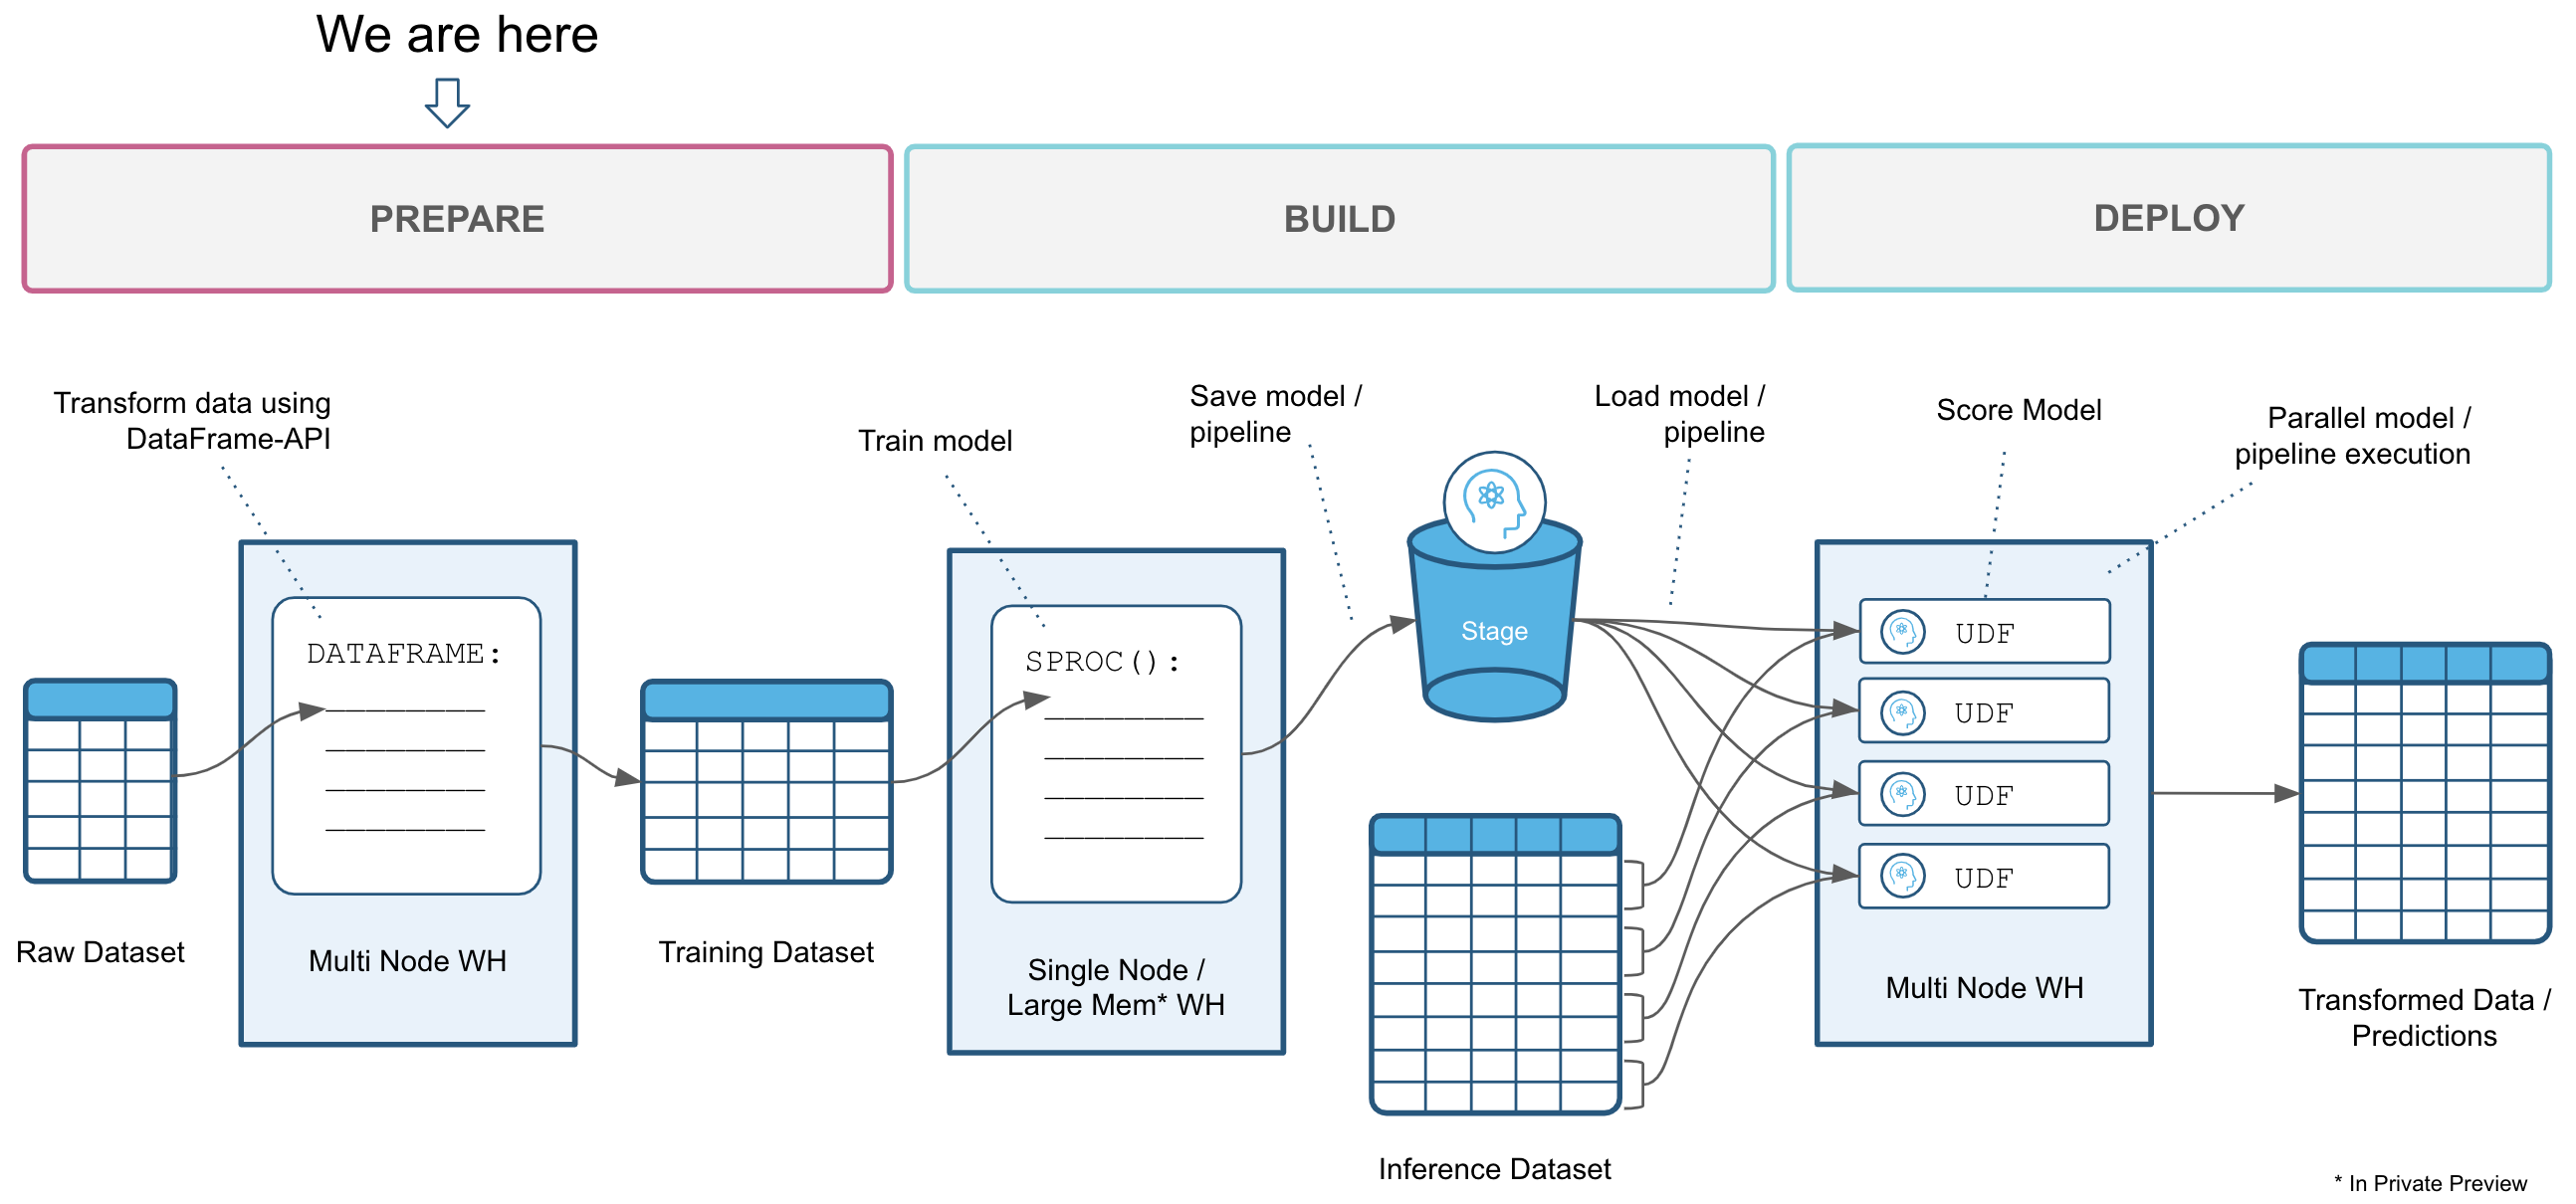

### Explore model features

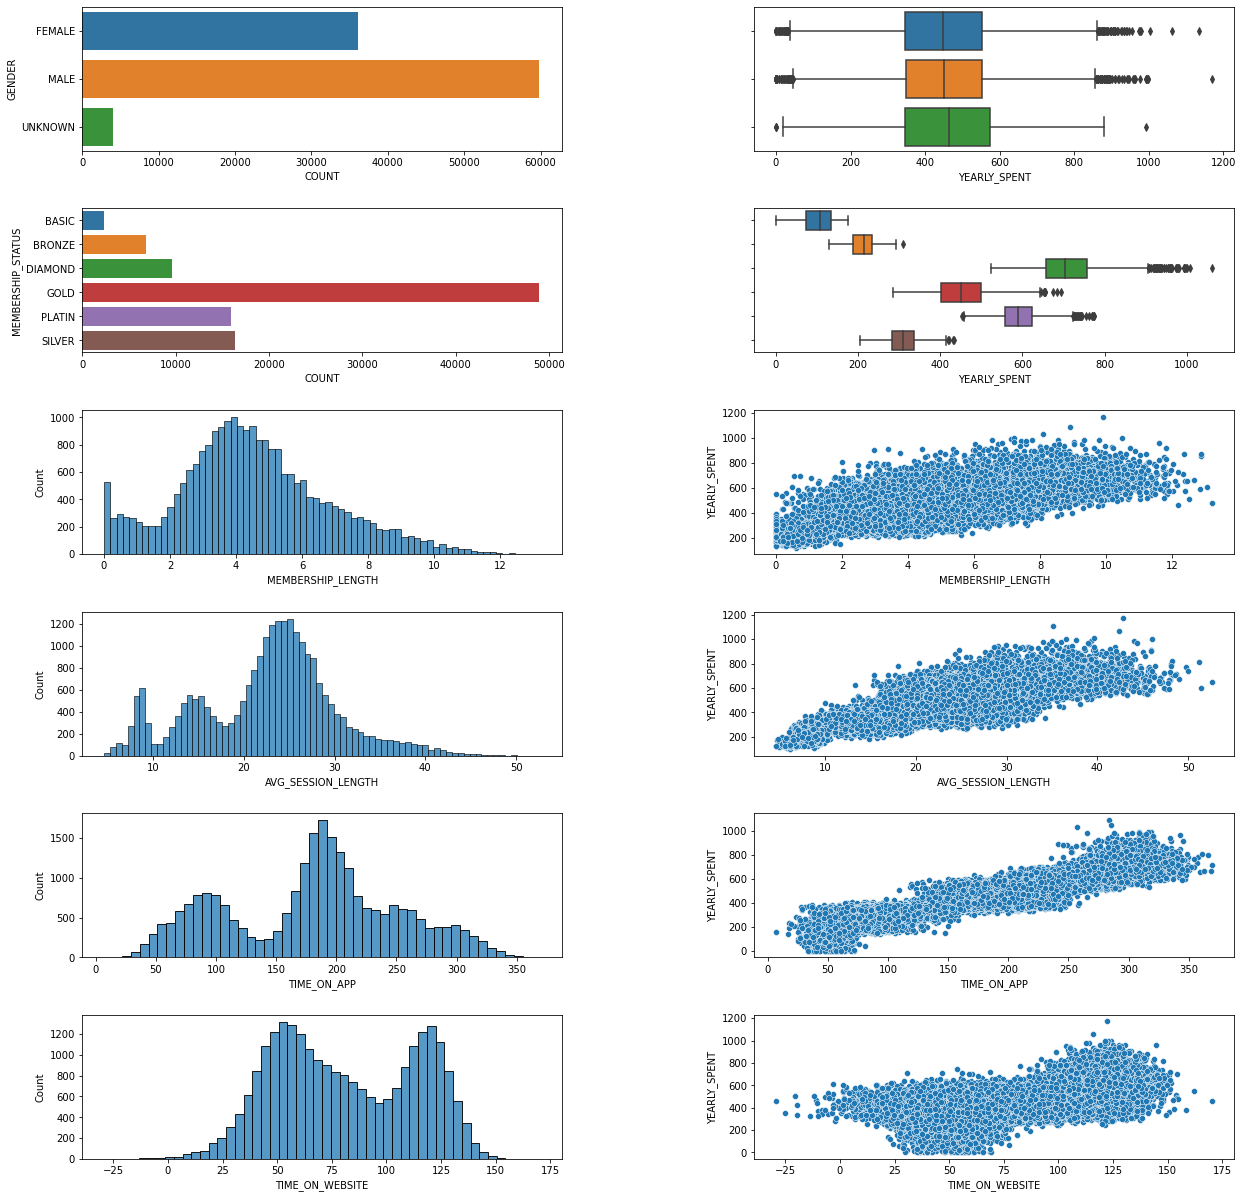

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
f, axs = plt.subplots(len(cat_attribs + num_attribs), 2, figsize=(20, 20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

counter = 0
for c in cat_attribs:
    df = snowdf.group_by(c).count().to_pandas()
    sns.barplot(x=df["COUNT"], y=df[c], ax=axs[counter, 0], order=sorted(df[c].to_list()))

    df2 = snowdf[[c,"YEARLY_SPENT"]].sample(.25).to_pandas()
    bp = sns.boxplot(x="YEARLY_SPENT", y=c, ax=axs[counter, 1], data=df2, order=sorted(df[c].to_list())).set(ylabel=None, yticklabels=[])

    counter+=1

for c in num_attribs:
    df = snowdf[[c, "YEARLY_SPENT"]].sample(.25).to_pandas()
    sns.histplot(data=df, x=c, ax=axs[counter, 0])

    sns.scatterplot(data=df, x=c, y="YEARLY_SPENT", ax=axs[counter, 1])

    counter+=1

## Exploring multiple methods to transform variables for One Hot Encoding

### Dataframe API Only

In [11]:
snowdf.select(F.col("GENDER"), 
              F.iff(F.col("GENDER") == "FEMALE", 1, 0 ).alias("GENDER_FEMALE"),
              F.iff(F.col("GENDER") == "MALE", 1, 0 ).alias("GENDER_MALE"),
              F.iff(F.col("GENDER") == "UNKNOWN", 1, 0 ).alias("GENDER_UNKNOWN"), 
).limit(100).to_pandas()

,GENDER,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN
0,FEMALE,1,0,0
1,FEMALE,1,0,0
2,MALE,0,1,0
3,MALE,0,1,0
4,FEMALE,1,0,0
...,...,...,...,...
95,FEMALE,1,0,0
96,MALE,0,1,0
97,MALE,0,1,0
98,MALE,0,1,0


### UDF
Scalar function
One Value -> One Value
Because we can only output one value, it requires some post-processing to get split the output of an array into different columns.

In [12]:
@udf(name="gender_encoder", replace=True)
def encode_gender(gender:str) -> list:
    gender_encoder = {
        'FEMALE':  [1,0,0],
        'MALE':    [0,1,0],
        'UNKNOWN': [0,0,1],
    }
    return gender_encoder[gender]

In [13]:
gender_encoded = snowdf.select(F.col("GENDER"), encode_gender(F.col("GENDER")).alias("gender_array"))
gender_encoded.limit(100).to_pandas()

,GENDER,GENDER_ARRAY
0,FEMALE,"[\n 1,\n 0,\n 0\n]"
1,FEMALE,"[\n 1,\n 0,\n 0\n]"
2,MALE,"[\n 0,\n 1,\n 0\n]"
3,MALE,"[\n 0,\n 1,\n 0\n]"
4,FEMALE,"[\n 1,\n 0,\n 0\n]"
...,...,...
95,FEMALE,"[\n 1,\n 0,\n 0\n]"
96,MALE,"[\n 0,\n 1,\n 0\n]"
97,MALE,"[\n 0,\n 1,\n 0\n]"
98,MALE,"[\n 0,\n 1,\n 0\n]"


In [14]:
gender_encoded.select(F.col("GENDER_ARRAY")[0].alias("GENDER_FEMALE"),
                      F.col("GENDER_ARRAY")[1].alias("GENDER_MALE"),
                      F.col("GENDER_ARRAY")[2].alias("GENDER_UNKNOWN"),  
               ).limit(100).to_pandas()

,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,1,0,0
...,...,...,...
95,1,0,0
96,0,1,0
97,0,1,0
98,0,1,0


We can use the UDF in SQL

In [15]:
session.sql("""select gender, 
                      gender_encoder(gender) as gender_encoder_array,
                      gender_encoder_array[0] as gender_female,
                      gender_encoder_array[1] as gender_male,
                      gender_encoder_array[2] as gender_unknown
               from 
                  ECOMMERCE_CUSTOMERS_100k a 
                limit 100 
""").to_pandas()

,GENDER,GENDER_ENCODER_ARRAY,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN
0,FEMALE,"[\n 1,\n 0,\n 0\n]",1,0,0
1,FEMALE,"[\n 1,\n 0,\n 0\n]",1,0,0
2,MALE,"[\n 0,\n 1,\n 0\n]",0,1,0
3,MALE,"[\n 0,\n 1,\n 0\n]",0,1,0
4,FEMALE,"[\n 1,\n 0,\n 0\n]",1,0,0
...,...,...,...,...,...
95,FEMALE,"[\n 1,\n 0,\n 0\n]",1,0,0
96,MALE,"[\n 0,\n 1,\n 0\n]",0,1,0
97,MALE,"[\n 0,\n 1,\n 0\n]",0,1,0
98,MALE,"[\n 0,\n 1,\n 0\n]",0,1,0


### UDTF
UDTFs be a different number of rows and columns than the input. This eliminates the post-processing necessary for the array output of the UDF above, but we need to define a Schema for the output, icnluding column names and data types.

In [16]:
@udtf(
    input_types=[T.StringType()],
    output_schema=T.StructType([T.StructField("GENDER_FEMALE", T.IntegerType()), 
                                T.StructField("GENDER_MALE", T.IntegerType()),
                                T.StructField("GENDER_UNKNOWN", T.IntegerType()),]),
    name="gender_encoder_udtf",
    replace=True,
)
class gender_encoder_udtf:
    def process(self, gender:str):
        gender_encoder = {
            'FEMALE':  [1,0,0],
            'MALE':    [0,1,0],
            'UNKNOWN': [0,0,1],
        }
        gender_encoded = gender_encoder[gender]
        yield (gender_encoded[0], gender_encoded[1], gender_encoded[2])
gender_encoder_udtf = F.table_function("gender_encoder_udtf")

In [17]:
gender_encoded = snowdf.select(gender_encoder_udtf(snowdf["GENDER"]))
gender_encoded.limit(100).to_pandas()

,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN
0,0,1,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
95,0,1,0
96,0,1,0
97,0,1,0
98,1,0,0


In [18]:
session.sql("""select gender, 
                      tf.*
               from 
                  ECOMMERCE_CUSTOMERS_100k a 
                  join table(gender_encoder_udtf(a.gender)) tf 
                limit 100 
""").to_pandas()

,GENDER,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN
0,FEMALE,1,0,0
1,MALE,0,1,0
2,FEMALE,1,0,0
3,MALE,0,1,0
4,FEMALE,1,0,0
...,...,...,...,...
95,MALE,0,1,0
96,MALE,0,1,0
97,FEMALE,1,0,0
98,FEMALE,1,0,0


## Train ML Model
Create a stored procedure to push ML training to Snowpark

In [19]:
snowdf_train, snowdf_test = snowdf.random_split([0.8, 0.2], seed=82) # use seed to make the split repeatable

snowdf_train.write.mode("overwrite").save_as_table("MEMBERSHIP_TRAIN")
snowdf_test.write.mode("overwrite").save_as_table("MEMBERSHIP_TEST")

### Transform Features
One Hot encode categorical features and impute and scale continuous features. We're using the `PREPROCESSING` module available here: [#https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities](#https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities). This module enables us to persist our transformers with the values fit from the training dataset, similar to the transformation tools built into scikit-learn.

#### One Hot Encoder for Categorical Features

In [20]:
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=cat_attribs)
one_hot_encoder.fit(snowdf)
train_ds = one_hot_encoder.transform(snowdf_train)
train_ds.limit(10).to_pandas()

,EMAIL,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER
0,u2otqqt9zm@mvkfh.com,5.888660,28.158552,267.363315,86.526823,593.047398,1,0,0,0,0,0,0,1,0
1,wb5wjjaqxy@t6rfz.com,3.498752,27.481113,235.796911,132.750487,537.462363,1,0,0,0,0,0,1,0,0
2,yxj7x9fv4v@c9xm0.com,6.255048,24.706348,161.974076,68.819486,586.785886,0,1,0,0,0,0,1,0,0
3,vxx9nj4zzl@4qi8i.com,7.100007,19.466667,185.490152,71.741045,541.195579,0,1,0,0,0,0,1,0,0
4,lqfuxk2yye@q6vkm.com,4.149268,21.907570,168.915367,49.228441,523.498353,1,0,0,0,0,0,1,0,0
5,zyw592ipl4@jjtts.com,2.475507,22.785610,190.663957,90.214381,475.882829,1,0,0,0,0,0,1,0,0
6,zimmyjayvf@cc8zy.com,3.750613,9.021774,121.163521,86.011650,276.153585,1,0,0,0,0,0,0,0,1
7,uylwvm0kba@euio4.com,3.908891,27.380003,169.418093,80.167749,382.280718,1,0,0,0,0,0,1,0,0
8,zxm5qc6uul@wz5na.com,5.540958,24.946123,209.815451,119.976333,535.160665,1,0,0,0,0,0,1,0,0
9,13gnfz2liu@d3zz0.com,2.252396,16.554653,107.699240,49.793487,319.050478,1,0,0,0,0,0,0,0,1


#### Impute null

In [21]:
simple_imputer = preprocessing.SimpleImputer(strategy="mean", input_cols=num_attribs)
simple_imputer.fit(train_ds)
train_ds = simple_imputer.transform(train_ds)
train_ds.limit(10).to_pandas()

,EMAIL,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER
0,u2otqqt9zm@mvkfh.com,5.888660,28.158552,267.363315,86.526823,593.047398,1,0,0,0,0,0,0,1,0
1,wb5wjjaqxy@t6rfz.com,3.498752,27.481113,235.796911,132.750487,537.462363,1,0,0,0,0,0,1,0,0
2,yxj7x9fv4v@c9xm0.com,6.255048,24.706348,161.974076,68.819486,586.785886,0,1,0,0,0,0,1,0,0
3,vxx9nj4zzl@4qi8i.com,7.100007,19.466667,185.490152,71.741045,541.195579,0,1,0,0,0,0,1,0,0
4,lqfuxk2yye@q6vkm.com,4.149268,21.907570,168.915367,49.228441,523.498353,1,0,0,0,0,0,1,0,0
5,zyw592ipl4@jjtts.com,2.475507,22.785610,190.663957,90.214381,475.882829,1,0,0,0,0,0,1,0,0
6,zimmyjayvf@cc8zy.com,3.750613,9.021774,121.163521,86.011650,276.153585,1,0,0,0,0,0,0,0,1
7,uylwvm0kba@euio4.com,3.908891,27.380003,169.418093,80.167749,382.280718,1,0,0,0,0,0,1,0,0
8,zxm5qc6uul@wz5na.com,5.540958,24.946123,209.815451,119.976333,535.160665,1,0,0,0,0,0,1,0,0
9,13gnfz2liu@d3zz0.com,2.252396,16.554653,107.699240,49.793487,319.050478,1,0,0,0,0,0,0,0,1


In [22]:
standard_scaler = preprocessing.StandardScaler(input_cols=num_attribs)
standard_scaler.fit(train_ds)
train_ds = standard_scaler.transform(train_ds)
train_ds.limit(10).to_pandas()

,EMAIL,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE
0,u2otqqt9zm@mvkfh.com,593.047398,1,0,0,0,0,0,0,1,0,0.601906,0.732035,1.220143,0.166201
1,wb5wjjaqxy@t6rfz.com,537.462363,1,0,0,0,0,0,1,0,0,-0.455501,0.642565,0.775616,1.587916
2,yxj7x9fv4v@c9xm0.com,586.785886,0,1,0,0,0,0,1,0,0,0.764013,0.276098,-0.263980,-0.378429
3,vxx9nj4zzl@4qi8i.com,541.195579,0,1,0,0,0,0,1,0,0,1.137863,-0.415913,0.067181,-0.288570
4,lqfuxk2yye@q6vkm.com,523.498353,1,0,0,0,0,0,1,0,0,-0.167682,-0.093540,-0.166230,-0.980997
5,zyw592ipl4@jjtts.com,475.882829,1,0,0,0,0,0,1,0,0,-0.908232,0.022424,0.140040,0.279620
6,zimmyjayvf@cc8zy.com,276.153585,1,0,0,0,0,0,0,0,1,-0.344066,-1.795382,-0.838686,0.150355
7,uylwvm0kba@euio4.com,382.280718,1,0,0,0,0,0,1,0,0,-0.274036,0.629211,-0.159151,-0.029387
8,zxm5qc6uul@wz5na.com,535.160665,1,0,0,0,0,0,1,0,0,0.448067,0.307766,0.409737,1.195017
9,13gnfz2liu@d3zz0.com,319.050478,1,0,0,0,0,0,0,0,1,-1.006947,-0.800506,-1.028294,-0.963617


In [23]:
train_ds.describe().to_pandas()

,SUMMARY,EMAIL,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE
0,count,80053,80053.000000,80053.000000,80053.000000,80053.000000,80053.000000,80053.000000,80053.000000,80053.000000,80053.000000,80053.000000,8.005300e+04,8.005300e+04,8.005300e+04,8.005300e+04
1,mean,None,451.098598,0.360461,0.599490,0.040048,0.023197,0.068555,0.096399,0.489039,0.159707,0.163104,-3.013730e-16,-7.442820e-16,4.894673e-16,-1.735281e-16
2,stddev,None,152.270460,0.480137,0.490005,0.196074,0.150529,0.252697,0.295139,0.499883,0.366336,0.369463,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
3,min,002vohjzbl@wxftu.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.003513e+00,-2.451896e+00,-2.485905e+00,-3.226561e+00
4,max,zzzx5pr2mq@mnejx.com,1170.450219,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.031974e+00,3.971248e+00,2.683755e+00,2.748781e+00


## Make a stored procedure to make a repeatable transformation process
Our fitted encoders are serialized and stored with the stored procedure, so we're able to easily reproduce our pipeline. 

In [24]:
@sproc(name="feature_engineering_sproc", stage_location="@udf", is_permanent=True, replace=True, imports=["@udf/preprocessing.zip"])
def feature_engineering(session:snowflake.snowpark.Session, input_table_name:str, output_table_name:str) -> str:
    df = session.table(input_table_name)
    
    # OneHot Encode categorical variables
    df = one_hot_encoder.transform(df)

    # Impute and scale numeric variables
    df = simple_imputer.transform(df)
    # removing standard scaler so no transform is necessary from Streamlit
    #df = standard_scaler.transform(df)

    # Write out to table
    df.write.mode("overwrite").save_as_table(output_table_name)

Use our `feature_engineering` SPROC to transform our train and test datasets.

In [25]:
feature_engineering(session, "MEMBERSHIP_TRAIN", "MEMBERSHIP_TRAIN_TRANSFORMED")
feature_engineering(session, "MEMBERSHIP_TEST", "MEMBERSHIP_TEST_TRANSFORMED")

In [26]:
session.table("MEMBERSHIP_TRAIN_TRANSFORMED").limit(100).to_pandas()

,EMAIL,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER
0,u2otqqt9zm@mvkfh.com,5.888660,28.158552,267.363315,86.526823,593.047398,1,0,0,0,0,0,0,1,0
1,wb5wjjaqxy@t6rfz.com,3.498752,27.481113,235.796911,132.750487,537.462363,1,0,0,0,0,0,1,0,0
2,yxj7x9fv4v@c9xm0.com,6.255048,24.706348,161.974076,68.819486,586.785886,0,1,0,0,0,0,1,0,0
3,vxx9nj4zzl@4qi8i.com,7.100007,19.466667,185.490152,71.741045,541.195579,0,1,0,0,0,0,1,0,0
4,lqfuxk2yye@q6vkm.com,4.149268,21.907570,168.915367,49.228441,523.498353,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,f0paf3irem@d3lyc.com,0.000000,16.393170,40.412769,50.791690,242.186133,0,1,0,0,1,0,0,0,0
96,miznh4hzkv@t7cmc.com,3.753085,14.288285,77.251361,45.924627,359.046645,1,0,0,0,0,0,1,0,0
97,imcrqls4ws@4qz2u.com,1.588435,14.223358,108.309652,39.569156,297.639355,1,0,0,0,0,0,0,0,1
98,wcbapojum8@b3nsm.com,3.283230,35.730353,288.668756,118.793160,742.743639,1,0,0,0,0,1,0,0,0


In [27]:
model_features =   session.table("MEMBERSHIP_TRAIN_TRANSFORMED").drop(["EMAIL", "YEARLY_SPENT"]).columns
model_features

['MEMBERSHIP_LENGTH',
 'AVG_SESSION_LENGTH',
 'TIME_ON_APP',
 'TIME_ON_WEBSITE',
 'GENDER_FEMALE',
 'GENDER_MALE',
 'GENDER_UNKNOWN',
 'MEMBERSHIP_STATUS_BASIC',
 'MEMBERSHIP_STATUS_BRONZE',
 'MEMBERSHIP_STATUS_DIAMOND',
 'MEMBERSHIP_STATUS_GOLD',
 'MEMBERSHIP_STATUS_PLATIN',
 'MEMBERSHIP_STATUS_SILVER']

### Create our Stored Procedure for fitting the model on Snowflake compute.

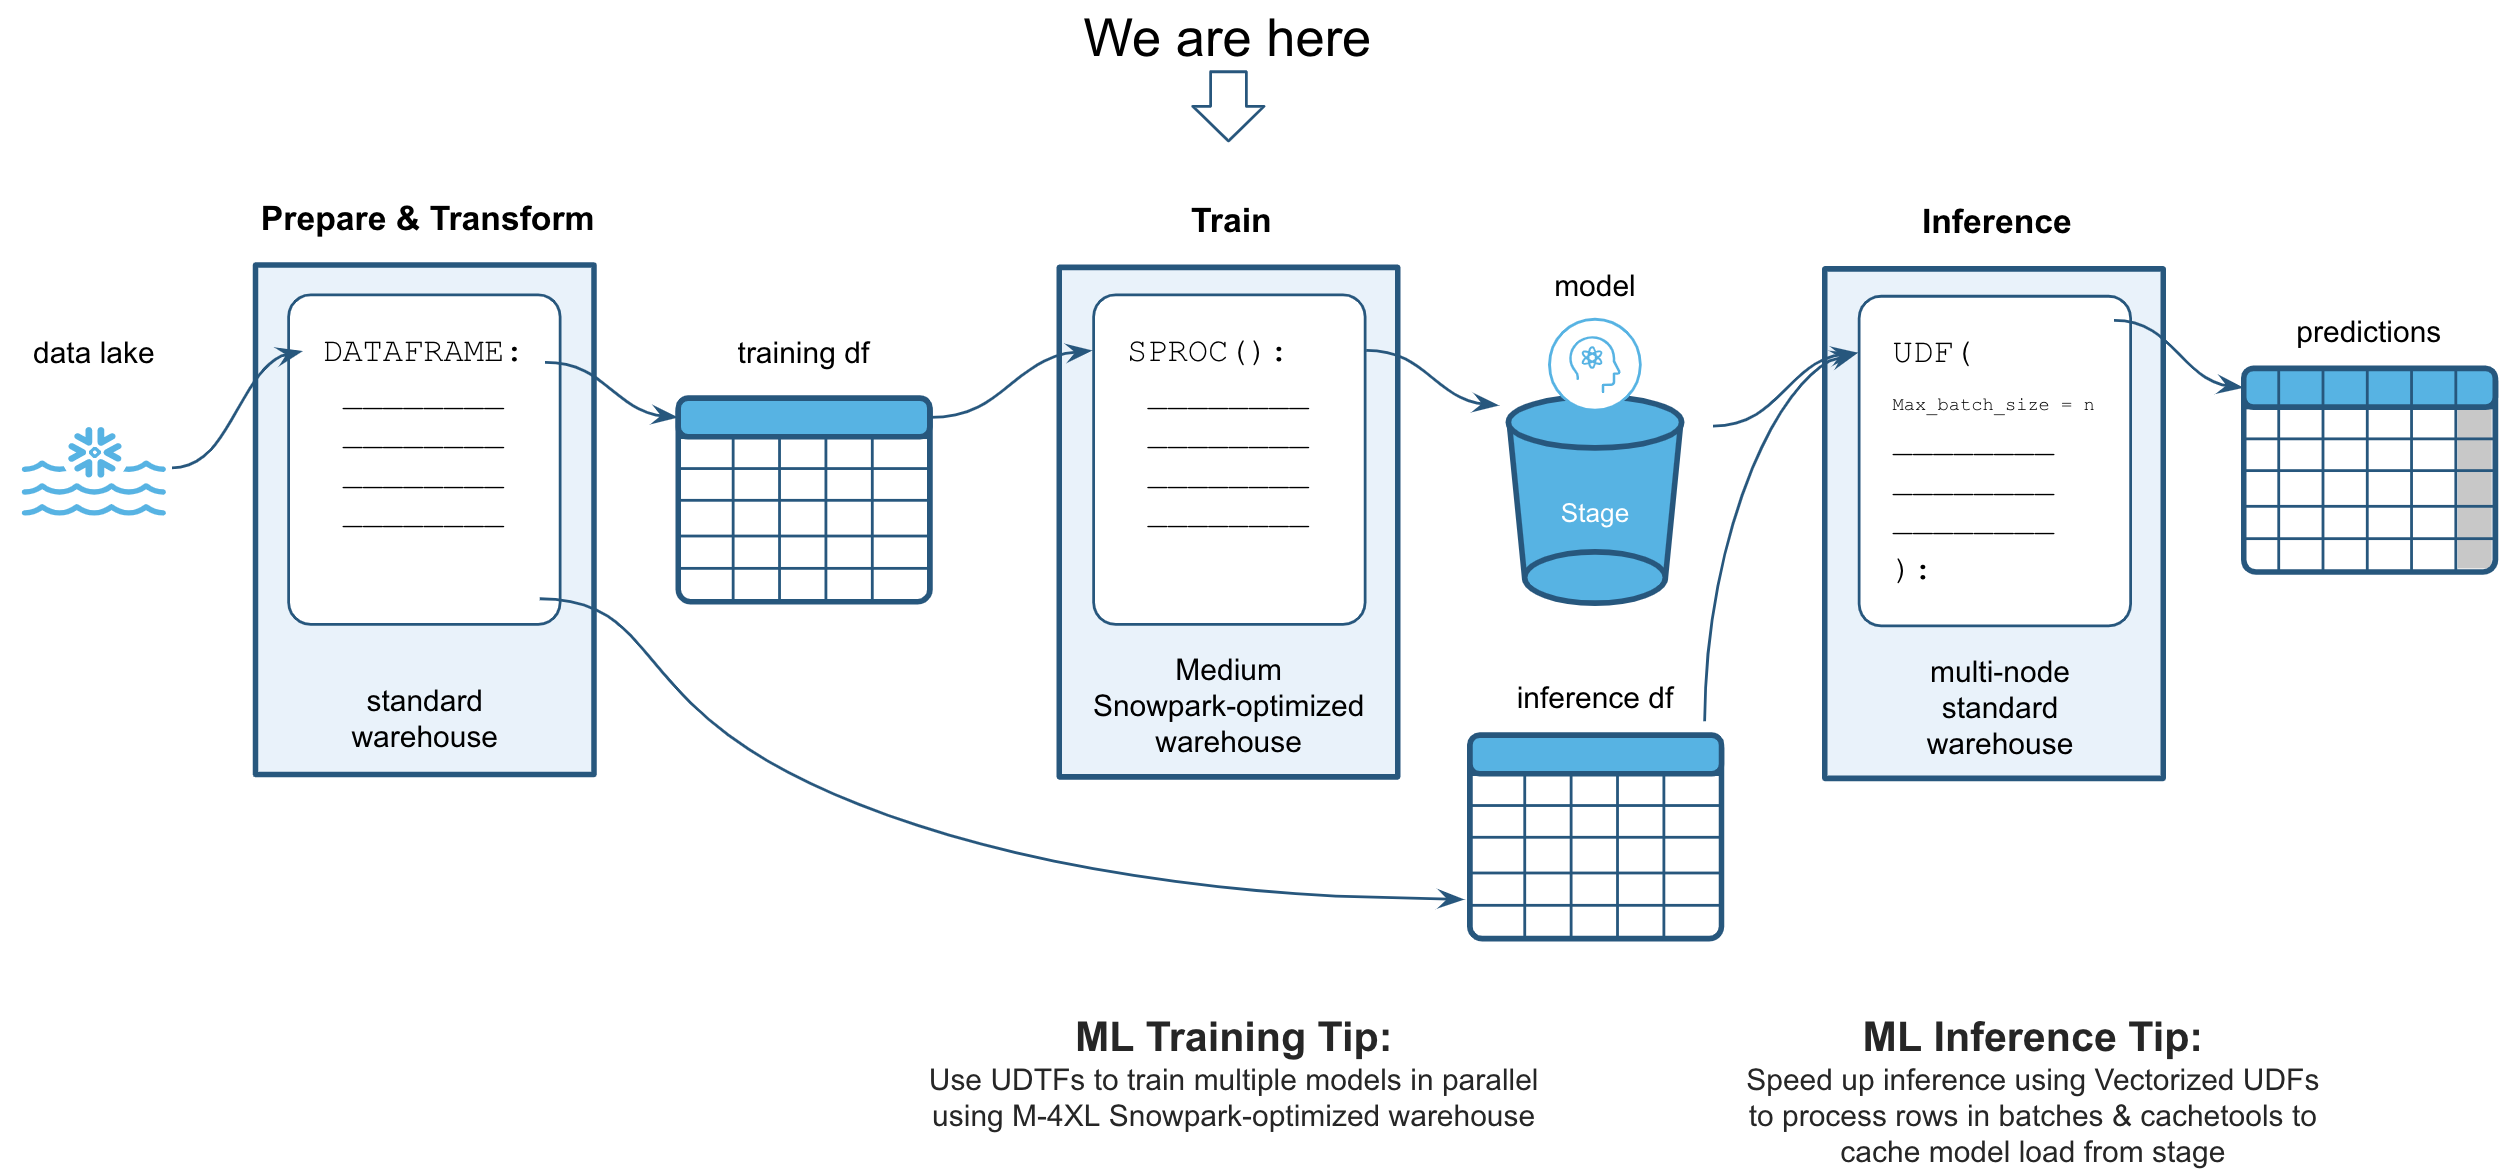

In [28]:
# Helper function to persist our model to our stage. 
# dumps the model to bytecode then uploads it to our stage
def save_file(session, model, path):
    model_output_dir = '/tmp'
    
    stage_folder   = '/'.join(path.split('/')[:-1])
    stage_filename = path.split('/')[-1]

    # dump model to temp space
    temp_file = os.path.join(model_output_dir, stage_filename)
    joblib.dump(model, temp_file)

    # put file to stage to persist
    session.file.put(temp_file, stage_folder, overwrite=True)
    return "successfully created file: " + path

# define our function that will be persisted as a stored procedure
def train_model(session: snowflake.snowpark.Session, train_table_name: str, test_table_name: str) -> float:
    train_df = session.table(train_table_name)
    train_df = train_df.drop("EMAIL")
    
    X_train = train_df.drop("YEARLY_SPENT").to_pandas() # drop labels 
    Y_train = train_df.select("YEARLY_SPENT").to_pandas()

    # fit the Random Forest Regressor model
    rfr = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr.fit(X_train, Y_train)

    # save the full pipeline including the model
    save_file(session, rfr, "@MODELS/member_ltv.joblib")

    # predict on the test set and return the root mean squared error (RMSE)
    test_df = session.table(test_table_name).drop("EMAIL")

    X_test = test_df.drop("YEARLY_SPENT").to_pandas() 
    Y_test = test_df.select("YEARLY_SPENT").to_pandas()

    Y_pred = rfr.predict(X_test)
    lin_mse = mean_squared_error(Y_test, Y_pred)
    lin_rmse = np.sqrt(lin_mse)

    return lin_rmse

# Create an instance of StoredProcedure using the sproc() function
train_model_sp = sproc(train_model, replace=True)

### Use high-memory warehouse for fitting our model.
This allows for single-node training. Warhouse `snowpark_demo_wh_high_mem` is a snowpark-optimized warehouse, size Medium. 

In [29]:
session.sql("USE WAREHOUSE snowpark_demo_wh_high_mem").collect()

[Row(status='Statement executed successfully.')]

Run our stored procedure to train our model.

In [30]:
train_model_sp("MEMBERSHIP_TRAIN_TRANSFORMED", "MEMBERSHIP_TEST_TRANSFORMED")

46.063032329161416

Switch back to standard warehouse. Model inference can be distributed across multiple nodes and don't need a large-memory warehouse.

In [31]:
# switch back to standard warehouse. Model inference can be distributed across multiple nodes and don't need a large-memory warehouse.
session.sql("USE WAREHOUSE snowpark_demo_wh").collect()

[Row(status='Statement executed successfully.')]

### Retrieve our model for additional analysis.

In [32]:
def retrieve_model(stage_location):
    import gzip 
    filename = stage_location.split('/')[-1]
    session.file.get(stage_location, '.')
    with gzip.open(filename, 'rb') as f:
        model_file = joblib.load(f)

    return model_file

rfr = retrieve_model("@MODELS/member_ltv.joblib.gz")

In [33]:
pd.DataFrame(rfr.feature_importances_,
             index=model_features, 
             columns=["FEAT_IMPORTANCE"]).sort_values("FEAT_IMPORTANCE", ascending=False)

,FEAT_IMPORTANCE
TIME_ON_APP,0.775806
MEMBERSHIP_STATUS_DIAMOND,0.038860
MEMBERSHIP_STATUS_BASIC,0.033304
TIME_ON_WEBSITE,0.031123
AVG_SESSION_LENGTH,0.030965
MEMBERSHIP_STATUS_PLATIN,0.027549
MEMBERSHIP_LENGTH,0.025274
MEMBERSHIP_STATUS_BRONZE,0.024890
MEMBERSHIP_STATUS_SILVER,0.005987
MEMBERSHIP_STATUS_GOLD,0.002693


## Deploy Model as UDF

### Inference Using Vectorized UDFs
Define the UDF that loads the model from the stage and makes predictions. 

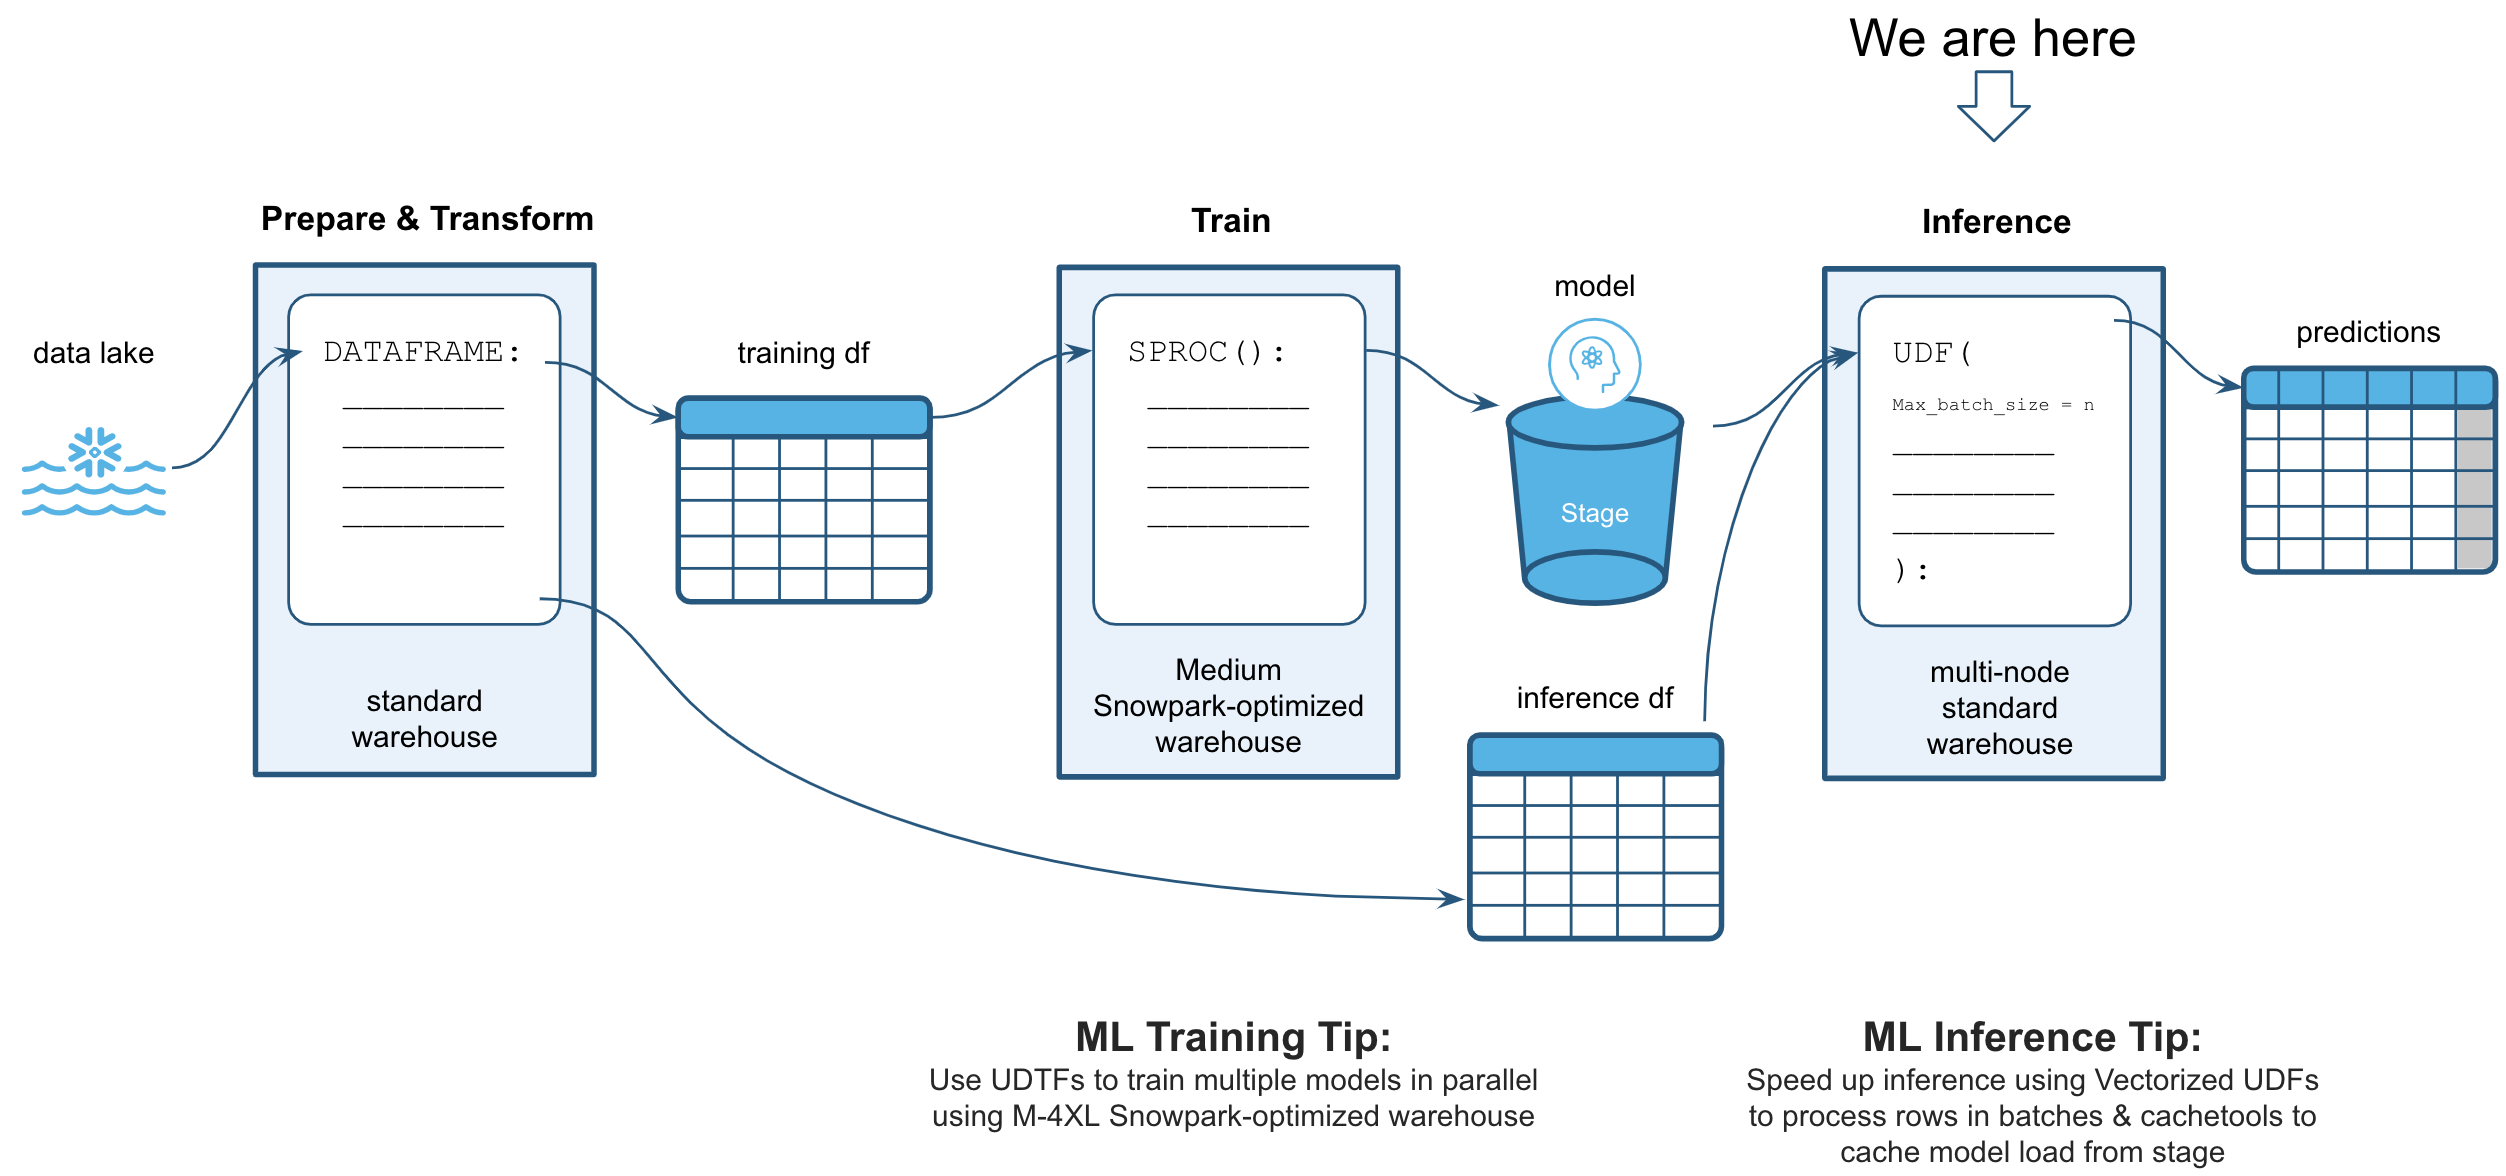

#### Deploy as UDF

In [34]:
import sys
from cachetools import cached
import os
session.add_import("@MODELS/member_ltv.joblib")  

@cached(cache={})
def read_file(filename):
       import_dir = sys._xoptions.get("snowflake_import_directory")
       if import_dir:
              with open(os.path.join(import_dir, filename), 'rb') as file:
                     m = joblib.load(file)
                     return m


@udf(name="predict", is_permanent=True, stage_location="@udf", replace=True)
def predict(  MEMBERSHIP_LENGTH:float,
              AVG_SESSION_LENGTH:float,
              TIME_ON_APP:float,
              TIME_ON_WEBSITE:float,
              GENDER_FEMALE:int,
              GENDER_MALE:int,
              GENDER_UNKNOWN:int,
              MEMBERSHIP_STATUS_BASIC:int,
              MEMBERSHIP_STATUS_BRONZE:int,
              MEMBERSHIP_STATUS_DIAMOND:int,
              MEMBERSHIP_STATUS_GOLD:int,
              MEMBERSHIP_STATUS_PLATIN:int,
              MEMBERSHIP_STATUS_SILVER:int) -> float:
       m = read_file('member_ltv.joblib')       
       features = model_features
       row = pd.DataFrame([locals()], columns=features)
       return m.predict(row)[0]

#### Deploy as Vectorized UDF
We're using a vectorized UDF, which automatically splits up the rows and sends a batch to each UDF execution resulting in better throughput. Additionally, we're caching the model load from stage to decrease IO cost. 

In [35]:
import pandas
import sys
import cachetools
import os
from snowflake.snowpark.functions import pandas_udf
from snowflake.snowpark import types as T

session.add_import("@MODELS/member_ltv.joblib")  
@cachetools.cached(cache={})
def read_file(filename):
       import_dir = sys._xoptions.get("snowflake_import_directory")
       if import_dir:
              with open(os.path.join(import_dir, filename), 'rb') as file:
                     m = joblib.load(file)
                     return m

@pandas_udf(name="predict_batch", is_permanent=True, stage_location="@udf", max_batch_size=1000, replace=True)
def predict_batch(df: T.PandasDataFrame[float, float, float, float, float, float, float, float, float, float, float, float, float, ]) -> T.PandasSeries[float]:
       m = read_file('member_ltv.joblib') 
       df.columns = model_features
       return m.predict(df)

### Run Inference UDF on 1 million records

Use our `feature_engineering` SPROC to prepare dataset of 1 million fresh records for model scoring 

In [36]:
session.call("FEATURE_ENGINEERING_SPROC", "ECOMMERCE_CUSTOMERS_1M", "INFERENCE_DATASET")

In [37]:
session.table("INFERENCE_DATASET").limit(100).to_pandas()

,EMAIL,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER
0,dnfb6sel3y@m0avu.com,5.238595,25.907610,159.446128,105.242873,462.364878,0,1,0,0,0,0,1,0,0
1,ygh93lh1w8@glozo.com,3.491633,28.802004,188.984853,77.549768,365.302529,0,1,0,0,0,0,1,0,0
2,z8ber6ndcc@q4v7n.com,4.528256,22.615821,41.375189,57.516271,88.293594,0,1,0,1,0,0,0,0,0
3,riycsd6guq@2hfrf.com,6.762742,35.689292,191.165244,35.398441,532.004765,1,0,0,0,0,0,1,0,0
4,cnlcl8gg1i@uyq7u.com,7.612121,38.104999,270.396186,117.166167,713.236305,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ilig0qr8fk@6kdci.com,4.047939,26.162015,208.351503,57.562364,380.113084,0,1,0,0,0,0,1,0,0
96,6okmau5o4t@os0va.com,4.528256,22.615821,42.423709,47.449933,90.538547,0,1,0,1,0,0,0,0,0
97,jfjr3uiyv5@askep.com,2.373303,28.393884,201.617906,49.207626,388.694185,1,0,0,0,0,0,1,0,0
98,yiw5tfunyo@gpaiw.com,9.046231,32.109221,227.916010,121.940651,615.491245,0,1,0,0,0,0,0,1,0


In [38]:
session.sql("ALTER WAREHOUSE SNOWPARK_DEMO_WH SET WAREHOUSE_SIZE='4X-LARGE' WAIT_FOR_COMPLETION=TRUE").collect()

[Row(status='Statement executed successfully.')]

Now running the vectorized UDF

In [39]:
inference_df = session.table("INFERENCE_DATASET")

scored_df = inference_df.select("*", 
                                F.call_udf("predict_batch", 
                                           *[F.col(c) for c in model_features]).alias("PREDICTED_YEARLY_SPENT")
                               )
scored_df.write.mode("OVERWRITE").save_as_table("INFERED_DATA_1M")
    
session.table("INFERED_DATA_1M").limit(100).to_pandas()

,EMAIL,MEMBERSHIP_LENGTH,AVG_SESSION_LENGTH,TIME_ON_APP,TIME_ON_WEBSITE,YEARLY_SPENT,GENDER_FEMALE,GENDER_MALE,GENDER_UNKNOWN,MEMBERSHIP_STATUS_BASIC,MEMBERSHIP_STATUS_BRONZE,MEMBERSHIP_STATUS_DIAMOND,MEMBERSHIP_STATUS_GOLD,MEMBERSHIP_STATUS_PLATIN,MEMBERSHIP_STATUS_SILVER,PREDICTED_YEARLY_SPENT
0,s7lu8e2pql@5ubmf.com,9.830889,35.081341,280.257832,111.689068,851.835398,1,0,0,0,0,1,0,0,0,745.875082
1,ma3ex0p6bj@h5wx7.com,9.326934,35.007242,266.824951,121.232014,685.649697,0,1,0,0,0,1,0,0,0,791.846926
2,0zvclqkxdh@xe35k.com,3.789280,12.787054,96.026840,68.473635,319.266989,1,0,0,0,0,0,0,0,1,312.584948
3,tihrikimzn@kupnz.com,4.648498,6.894552,112.883987,55.253902,257.193131,0,1,0,0,0,0,0,0,1,289.892829
4,2sbjsvcuwh@9nw6m.com,3.077580,11.110258,120.087913,68.040453,273.303338,0,1,0,0,0,0,0,0,1,326.826052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4l3x3hylbi@pvv7w.com,4.497781,21.778516,198.445479,79.614406,465.484079,1,0,0,0,0,0,1,0,0,436.737413
96,tkmjvvrxyl@0jc8i.com,3.418741,14.813022,91.984681,54.063261,279.339105,1,0,0,0,0,0,0,0,1,291.547851
97,rpm1svatky@dgs6e.com,3.449411,30.926727,255.523060,105.266730,608.596229,0,1,0,0,0,0,0,1,0,590.946105
98,lgorjarroo@z4vqc.com,9.993902,24.287602,274.928648,133.992081,670.731697,0,1,0,0,0,1,0,0,0,676.380919


## Parallelize hyperparameter tuning UDTF
Fit > 280 models in parallel to find ideal hyperparameters for our model. See [Chase Romano's Medium Article on Hyperparameter Tuning](https://medium.com/@chasea.romano/parallel-hyperparameter-tuning-using-snowpark-53cdec2faf77) for tutorial.

In [40]:
from functools import reduce
param_grid = {
    "BOOTSTRAP": [True],
    "MAX_DEPTH": [80, 90, 100, 110],
    "MAX_FEATURES": [2, 3],
    "MIN_SAMPLES_LEAF": [3, 4, 5],
    "MIN_SAMPLES_SPLIT": [8, 10, 12],
    "N_ESTIMATORS": [100, 200, 300, 1000],
}
dfs = []
for k, v in param_grid.items():
    df = pd.DataFrame(v, columns=[k])
    dfs.append(df)

df = reduce(lambda left, right: pd.merge(left, right, how="cross"), dfs)
params_df = session.create_dataframe(df)

params_df = params_df.select(
    "*", F.row_number().over(Window.order_by(F.lit(1))).as_("HP_ID")
)

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


In [41]:
# look at our hyperparameter grid
params_df.to_pandas()

,BOOTSTRAP,MAX_DEPTH,MAX_FEATURES,MIN_SAMPLES_LEAF,MIN_SAMPLES_SPLIT,N_ESTIMATORS,HP_ID
0,True,80,2,3,8,100,1
1,True,80,2,3,8,200,2
2,True,80,2,3,8,300,3
3,True,80,2,3,8,1000,4
4,True,80,2,3,10,100,5
...,...,...,...,...,...,...,...
283,True,110,3,5,10,1000,284
284,True,110,3,5,12,100,285
285,True,110,3,5,12,200,286
286,True,110,3,5,12,300,287


In [42]:
train_df = session.table("MEMBERSHIP_TRAIN_TRANSFORMED").drop("EMAIL")
train_df_hp = params_df.cross_join(train_df)

In [43]:
# output schema for hyperparameter tuning
schema = T.StructType(
    [
        T.StructField("BOOTSTRAP1", T.BooleanType()),
        T.StructField("MAX_DEPTH1", T.IntegerType()),
        T.StructField("MAX_FEATURES1", T.IntegerType()),
        T.StructField("MIN_SAMPLES_SPLIT1", T.IntegerType()),
        T.StructField("MIN_SAMPLES_LEAF1", T.IntegerType()),
        T.StructField("N_ESTIMATORS1", T.IntegerType()),
        T.StructField("RMSE", T.FloatType()),
    ]
)
input_types = [
         T.BooleanType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.DoubleType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.LongType(),
         T.DoubleType(),
         T.DoubleType(),
         T.DoubleType(),
         T.DoubleType(),
        ]

In [44]:
@udtf(
    output_schema=schema,
    input_types=input_types,
    name="hyperparameter_tuning",
    session=session,
    is_permanent=True,
    stage_location="@udf",
    packages=["snowflake-snowpark-python", "pandas", "scikit-learn"],
    replace=True,
)
class hp_tuning:
    #Initializes state for stateful processing of input partitions
    def __init__(self):
        self.BOOTSTRAP = None
        self.MAX_DEPTH = None
        self.MAX_FEATURES = None
        self.MIN_SAMPLES_SPLIT = None
        self.MIN_SAMPLES_LEAF = None
        self.N_ESTIMATORS = None
        self.YEARLY_SPENT = []
        self.MEMBERSHIP_STATUS_BASIC = []
        self.MEMBERSHIP_STATUS_BRONZE = []
        self.MEMBERSHIP_STATUS_DIAMOND = []
        self.MEMBERSHIP_STATUS_GOLD = []
        self.MEMBERSHIP_STATUS_PLATIN = []
        self.MEMBERSHIP_STATUS_SILVER = []
        self.GENDER_FEMALE = []
        self.GENDER_MALE = []
        self.GENDER_UNKNOWN = []
        self.MEMBERSHIP_LENGTH = []
        self.AVG_SESSION_LENGTH = []
        self.TIME_ON_APP = []
        self.TIME_ON_WEBSITE = []
        self.processedFirstRow = False
    # Processes each input row, returning a tabular value as tuples. Snowflake invokes this method, passing input from the UDTF's arguments.
    def process(
        self,
        BOOTSTRAP,
        MAX_DEPTH,
        MAX_FEATURES,
        MIN_SAMPLES_SPLIT,
        MIN_SAMPLES_LEAF,
        N_ESTIMATORS,
        YEARLY_SPENT,
        MEMBERSHIP_STATUS_BASIC,
        MEMBERSHIP_STATUS_BRONZE,
        MEMBERSHIP_STATUS_DIAMOND,
        MEMBERSHIP_STATUS_GOLD,
        MEMBERSHIP_STATUS_PLATIN,
        MEMBERSHIP_STATUS_SILVER,
        GENDER_FEMALE,
        GENDER_MALE,
        GENDER_UNKNOWN,
        MEMBERSHIP_LENGTH,
        AVG_SESSION_LENGTH,
        TIME_ON_APP,
        TIME_ON_WEBSITE
    ):
    # We are telling the UDTF only to run 288 models based on the unique combination of hyperparameters rather than every record in our data set.
        if not self.processedFirstRow:
            self.BOOTSTRAP = BOOTSTRAP
            self.MAX_DEPTH = MAX_DEPTH
            self.MAX_FEATURES = MAX_FEATURES
            self.MIN_SAMPLES_SPLIT = MIN_SAMPLES_SPLIT
            self.MIN_SAMPLES_LEAF = MIN_SAMPLES_LEAF
            self.N_ESTIMATORS = N_ESTIMATORS
            self.processedFirstRow = True
        self.YEARLY_SPENT.append(YEARLY_SPENT)
        self.MEMBERSHIP_STATUS_BASIC.append(MEMBERSHIP_STATUS_BASIC)
        self.MEMBERSHIP_STATUS_BRONZE.append(MEMBERSHIP_STATUS_BRONZE)
        self.MEMBERSHIP_STATUS_DIAMOND.append(MEMBERSHIP_STATUS_DIAMOND)
        self.MEMBERSHIP_STATUS_GOLD.append(MEMBERSHIP_STATUS_GOLD)
        self.MEMBERSHIP_STATUS_PLATIN.append(MEMBERSHIP_STATUS_PLATIN)
        self.MEMBERSHIP_STATUS_SILVER.append(MEMBERSHIP_STATUS_SILVER)
        self.GENDER_FEMALE.append(GENDER_FEMALE)
        self.GENDER_MALE.append(GENDER_MALE)
        self.GENDER_UNKNOWN.append(GENDER_UNKNOWN)
        self.MEMBERSHIP_LENGTH.append(MEMBERSHIP_LENGTH)
        self.AVG_SESSION_LENGTH.append(AVG_SESSION_LENGTH)
        self.TIME_ON_APP.append(TIME_ON_APP)
        self.TIME_ON_WEBSITE.append(TIME_ON_WEBSITE)

    def end_partition(self):
    # Finalizes processing of input partitions, returning a tabular value as tuples.
    # Together the process is used to add the rows of a partition into the x1, x2 … lists, and then 
    # end_partition is called when all rows have been processed, and we then can train the model based on the hyperparameters in the first row
        df = pd.DataFrame(
            zip(    self.YEARLY_SPENT,
                    self.MEMBERSHIP_STATUS_BASIC,
                    self.MEMBERSHIP_STATUS_BRONZE,
                    self.MEMBERSHIP_STATUS_DIAMOND,
                    self.MEMBERSHIP_STATUS_GOLD,
                    self.MEMBERSHIP_STATUS_PLATIN,
                    self.MEMBERSHIP_STATUS_SILVER,
                    self.GENDER_FEMALE,
                    self.GENDER_MALE,
                    self.GENDER_UNKNOWN,
                    self.MEMBERSHIP_LENGTH,
                    self.AVG_SESSION_LENGTH,
                    self.TIME_ON_APP,
                    self.TIME_ON_WEBSITE),
            columns=['YEARLY_SPENT',
                    'MEMBERSHIP_STATUS_BASIC',
                    'MEMBERSHIP_STATUS_BRONZE',
                    'MEMBERSHIP_STATUS_DIAMOND',
                    'MEMBERSHIP_STATUS_GOLD',
                    'MEMBERSHIP_STATUS_PLATIN',
                    'MEMBERSHIP_STATUS_SILVER',
                    'GENDER_FEMALE',
                    'GENDER_MALE',
                    'GENDER_UNKNOWN',
                    'MEMBERSHIP_LENGTH',
                    'AVG_SESSION_LENGTH',
                    'TIME_ON_APP',
                    'TIME_ON_WEBSITE']
        )

        dfx = df.loc[:, df.columns != "YEARLY_SPENT"]
        dfy = df.loc[:, df.columns == "YEARLY_SPENT"]

        X_train, X_test, y_train, y_test = train_test_split(
            dfx, dfy, test_size=0.2, random_state=0
        )

        clf = RandomForestRegressor(
            bootstrap=self.BOOTSTRAP,
            max_depth=self.MAX_DEPTH,
            max_features=self.MAX_FEATURES,
            min_samples_split=self.MIN_SAMPLES_SPLIT,
            min_samples_leaf=self.MIN_SAMPLES_LEAF,
            n_estimators=self.N_ESTIMATORS,
            n_jobs=1,
        )

        clf.fit(X_train, y_train.values.ravel())

        y_pred = clf.predict(X_test)

        yield (
            self.BOOTSTRAP,
            self.MAX_DEPTH,
            self.MAX_FEATURES,
            self.MIN_SAMPLES_SPLIT,
            self.MIN_SAMPLES_LEAF,
            self.N_ESTIMATORS,
            np.sqrt(mean_squared_error(y_test, y_pred))
        )



In [45]:
session.sql("ALTER WAREHOUSE snowpark_demo_wh_high_mem set warehouse_size='X3LARGE' WAIT_FOR_COMPLETION=TRUE").collect()

[Row(status='Statement executed successfully.')]

In [46]:
session.sql("USE WAREHOUSE snowpark_demo_wh_high_mem").collect()

[Row(status='Statement executed successfully.')]

In [47]:
#Calling the UDTF to get your most accurate hyperparameters
HP_TUNING = F.table_function("hyperparameter_tuning")
model_results = train_df_hp.select(
    train_df_hp["HP_ID"],
    (
        HP_TUNING(
            train_df_hp["BOOTSTRAP"],
            train_df_hp["MAX_DEPTH"],
            train_df_hp["MAX_FEATURES"],
            train_df_hp["MIN_SAMPLES_SPLIT"],
            train_df_hp["MIN_SAMPLES_LEAF"],
            train_df_hp["N_ESTIMATORS"],
            train_df_hp["YEARLY_SPENT"],
            train_df_hp["MEMBERSHIP_STATUS_BASIC"],
            train_df_hp["MEMBERSHIP_STATUS_BRONZE"],
            train_df_hp["MEMBERSHIP_STATUS_DIAMOND"],
            train_df_hp["MEMBERSHIP_STATUS_GOLD"],
            train_df_hp["MEMBERSHIP_STATUS_PLATIN"],
            train_df_hp["MEMBERSHIP_STATUS_SILVER"],
            train_df_hp["GENDER_FEMALE"],
            train_df_hp["GENDER_MALE"],
            train_df_hp["GENDER_UNKNOWN"],
            train_df_hp["MEMBERSHIP_LENGTH"],
            train_df_hp["AVG_SESSION_LENGTH"],
            train_df_hp["TIME_ON_APP"],
            train_df_hp["TIME_ON_WEBSITE"],
        ).over(partition_by=train_df_hp["HP_ID"])
    )
).sort(F.col('RMSE').desc())


The creation of the UDTF above is evaluated lazily. Running the code below kicks off our hyperparameter tuning.

In [48]:
model_results.to_pandas().sort_values('RMSE', ascending=False)

,HP_ID,BOOTSTRAP1,MAX_DEPTH1,MAX_FEATURES1,MIN_SAMPLES_SPLIT1,MIN_SAMPLES_LEAF1,N_ESTIMATORS1,RMSE
0,182,True,90,2,8,3,100,46.257899
1,190,True,80,3,8,3,100,46.255506
2,224,True,80,2,8,3,100,46.249957
3,90,True,110,2,8,3,100,46.243463
4,171,True,100,3,8,3,100,46.238435
...,...,...,...,...,...,...,...,...
283,85,True,90,3,12,5,1000,45.958199
284,49,True,100,2,8,5,1000,45.956495
285,243,True,100,3,12,5,1000,45.944799
286,239,True,110,3,12,5,1000,45.940522


We can now use the hyperparameters from our best model to train a model with those settings using a stored procedure and deploy the model with a Vectorized UDF.